In [1]:
from pathlib import Path
import pandas as pd
import sys
import os
import torch
import numpy as np

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

In [2]:
from src.data_extractor.stocks import read_and_concat_all_stocks
from src.training.preparation import (
    time_series_train_test_split,
    separate_the_target_column,
    prepare_nn_multistep_dataset
)
from src.training.feature_engineering import add_date_as_feature, add_lagged_features

In [3]:
data_folder = "../data/"
data_folder_path = Path(data_folder)

target_stocks = [
    "AAPL",
    "GOOGL",
    "AMZN",
    "TSLA",
    "NVDA",
    "MSFT",
    "META"
]

target_column = "AAPL"
n_lags = 3
output_size = 5
validation_size = 30

In [4]:
data = read_and_concat_all_stocks(data_folder_path)
data.shape

(3909, 424)

In [5]:
data = add_date_as_feature(data)
data.shape

(3909, 427)

In [6]:
data_lagged = add_lagged_features(data, target_column, n_lags=n_lags)
data_lagged.shape

(3906, 1282)

In [7]:
X, y = separate_the_target_column(data_lagged, target_column=target_column)

In [8]:
print(f"Feature dataset size: {X.shape}")
print(f"Target size: {y.shape}")

Feature dataset size: (3906, 1281)
Target size: (3906,)


In [136]:
X_train_raw, X_valid_raw, y_train_raw, y_valid_raw = time_series_train_test_split(X=X,
                                                                                  y=y,
                                                                                  validation_window=validation_size)

In [137]:
print(f"X_train_raw data shape: {X_train_raw.shape}")
print(f"X_valid_raw data shape: {X_valid_raw.shape}")
print(f"y_train_raw data shape: {y_train_raw.shape}")
print(f"y_valid_raw data shape: {y_valid_raw.shape}")

X_train_raw data shape: (3876, 1281)
X_valid_raw data shape: (30, 1281)
y_train_raw data shape: (3876,)
y_valid_raw data shape: (30,)


In [138]:
X_train, y_train = prepare_nn_multistep_dataset(X_train_raw, y_train_raw, prediction_window=output_size)
X_valid, y_valid = prepare_nn_multistep_dataset(X_valid_raw, y_valid_raw, prediction_window=output_size)

In [139]:
print(f"X_train processed data shape: {X_train.shape}")
print(f"X_valid processed data shape: {X_valid.shape}")
print(f"y_train processed data shape: {y_train.shape}")
print(f"y_valid processed data shape: {y_valid.shape}")

X_train processed data shape: torch.Size([3876, 1281])
X_valid processed data shape: torch.Size([30, 1281])
y_train processed data shape: torch.Size([3876, 5])
y_valid processed data shape: torch.Size([30, 5])


In [140]:
# Get the input size
input_size = X_train.shape[1]
hidden_dim = 256
learning_rate = 0.0001
batch_size=128
n_epochs = 100

In [141]:
from src.training.models import FeedforwardRegressor
from src.training.loss_functions import masked_mse_loss
from src.training.trainers import trainer

from torch.utils.data import DataLoader, TensorDataset

In [142]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Wrap training data into a DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [143]:
# Initialize model and optimizer
model = FeedforwardRegressor(input_dim=input_size,
                             output_dim=output_size,
                             hidden_dim=hidden_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [144]:
trainer(model=model,
        train_loader=train_loader,
        X_valid=X_valid,
        y_valid=y_valid,
        optimizer=optimizer,
        loss_fn=masked_mse_loss,
        n_epochs=n_epochs,
        device=device
)

Epoch 1/100 - Train Loss: 1524.6130 - Val Loss: 241.7293
Epoch 2/100 - Train Loss: 206.8188 - Val Loss: 544.5618
Epoch 3/100 - Train Loss: 111.5867 - Val Loss: 407.3692
Epoch 4/100 - Train Loss: 89.1599 - Val Loss: 253.5066
Epoch 5/100 - Train Loss: 78.3608 - Val Loss: 278.7504
Epoch 6/100 - Train Loss: 70.4306 - Val Loss: 288.0944
Epoch 7/100 - Train Loss: 67.0911 - Val Loss: 260.8861
Epoch 8/100 - Train Loss: 63.4435 - Val Loss: 302.1012
Epoch 9/100 - Train Loss: 61.0647 - Val Loss: 151.7528
Epoch 10/100 - Train Loss: 59.4385 - Val Loss: 261.3135
Epoch 11/100 - Train Loss: 57.2567 - Val Loss: 143.6708
Epoch 12/100 - Train Loss: 53.7643 - Val Loss: 202.1446
Epoch 13/100 - Train Loss: 51.7330 - Val Loss: 207.3183
Epoch 14/100 - Train Loss: 49.3818 - Val Loss: 264.1301
Epoch 15/100 - Train Loss: 48.8858 - Val Loss: 237.9239
Epoch 16/100 - Train Loss: 47.2163 - Val Loss: 210.1494
Epoch 17/100 - Train Loss: 45.9791 - Val Loss: 160.9554
Epoch 18/100 - Train Loss: 43.4654 - Val Loss: 336.50

FeedforwardRegressor(
  (model): Sequential(
    (0): Linear(in_features=1281, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [145]:
import matplotlib.pyplot as plt

In [146]:
# 1. Move model and data to appropriate device
model.eval()
X_train_cpu = X_train.to(device)
y_train_cpu = y_train.to(device)
X_valid_cpu = X_valid.to(device)
y_valid_cpu = y_valid.to(device)

# 2. Predict outputs
with torch.no_grad():
    y_train_pred = model(X_train_cpu)
    y_valid_pred = model(X_valid_cpu)

# 3. Convert to numpy
y_train_true = y_train_cpu.cpu().numpy()
y_train_pred = y_train_pred.cpu().numpy()
y_valid_true = y_valid_cpu.cpu().numpy()
y_valid_pred = y_valid_pred.cpu().numpy()

In [147]:
y_train_true.shape, y_train_pred.shape, y_valid_true.shape, y_valid_pred.shape

((3876, 5), (3876, 5), (30, 5), (30, 5))

In [148]:
def collect_predictions_per_timestamp(y_pred):
    y_pred = np.asarray(y_pred)
    n_windows, window = y_pred.shape
    

    # Store predictions as lists per timestamp
    all_preds = [[] for _ in range(n_windows)]

    for i in range(n_windows):
        for j in range(window):
            t = i + j
            if t < n_windows and y_pred[i, j] != 0:
                all_preds[t].append(y_pred[i, j])

    # Pad to length 7 (or fill with NaNs) for consistency
    padded_preds = np.full((n_windows, output_size), np.nan)
    for t, preds in enumerate(all_preds):
        padded_preds[t, :len(preds)] = preds

    return padded_preds

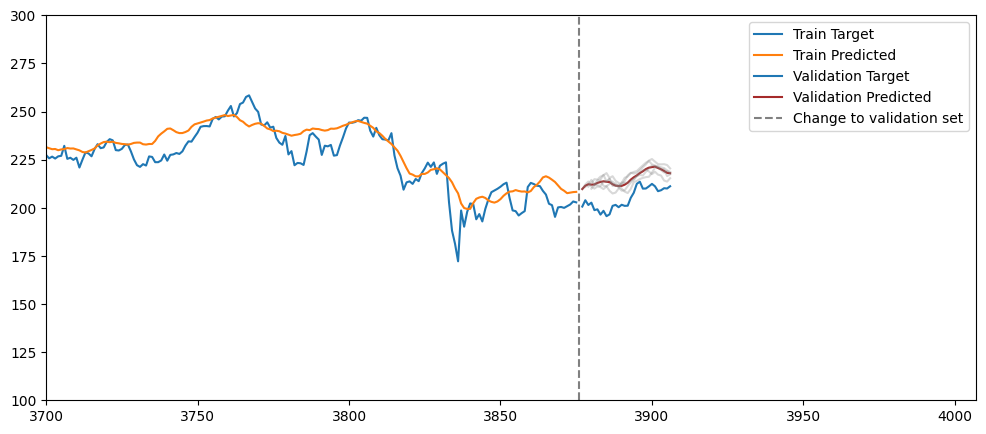

In [149]:
# 4. Plot
plt.figure(figsize=(12, 5))

# Train and it's target
train_end = len(y_train_raw)
plt.plot(range(train_end), y_train_raw, label="Train Target", color="tab:blue")

train_predicted_avg = collect_predictions_per_timestamp(y_train_pred)
plt.plot(range(train_end), np.nanmean(train_predicted_avg, axis=1), label="Train Predicted", color="tab:orange")

# Validation and it's target
valid_start = train_end+1
valid_end = train_end + len(y_valid_raw) + 1 
plt.plot(range(valid_start, valid_end), y_valid_raw, label="Validation Target", color="tab:blue")

valid_predicted = collect_predictions_per_timestamp(y_valid_pred)
plt.plot(range(valid_start, valid_end), np.nanmean(valid_predicted, axis=1), label="Validation Predicted", color="brown")
plt.plot(range(valid_start, valid_end), valid_predicted, color="gray", alpha=0.3)

plt.axvline(x=train_end, color='gray', linestyle='--', label='Change to validation set')

plt.xlim(3700, valid_end+100)
plt.ylim(100, 300)

plt.legend()
plt.show()

